In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.autograd import Variable

torch.manual_seed(1)

In [33]:
from nltk.tokenize import word_tokenize

In [34]:
from tqdm import tqdm

#### Data processing

In [35]:
# Open and read in text
text_file = open('short_story.txt', 'r')
raw_text = text_file.read().lower()
text_file.close()

# Create tokenized text (list) and vocabulary (set of unique words)
token_text = word_tokenize(raw_text)
len_token_text = len(token_text)

print("# of tokens: ", len(token_text), '\n', token_text[:10])

# of tokens:  5526 
 ['the', 'last', 'question', 'was', 'asked', 'for', 'the', 'first', 'time', ',']


In [36]:
# set of vocab items
vocab = set(token_text)
vocab_size = len(vocab)
print("size of vocabulary: ", vocab_size)

# dictionaries mapping from word to index and vica versa
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

size of vocabulary:  1115


In [37]:
# "Unless otherwise noted, we use a context of ten words to the left and
# ten words to the right."
CONTEXT_SIZE = 10

# Construct co-occurence matrix
co_occ_mat = np.zeros((vocab_size, vocab_size))
for i in range(len_token_text):
    for dist in range(1, CONTEXT_SIZE + 1):
        ix = word_to_ix[token_text[i]]
        if i - dist > 0:
            left_ix = word_to_ix[token_text[i - dist]]
            co_occ_mat[ix, left_ix] += 1.0 / dist
        if i + dist < len_token_text:
            right_ix = word_to_ix[token_text[i + dist]]
            co_occ_mat[ix, right_ix] += 1.0 / dist

# Non-zero co-occurrences
# https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.nonzero.html
# returns a 2-D array, with a row for each non-zero element            
co_occs = np.transpose(np.nonzero(co_occ_mat))

print("shape of co-occurrence matrix:", co_occ_mat.shape)
print("non-zero co-occurrences:\n", co_occs)

shape of co-occurrence matrix: (1115, 1115)
non-zero co-occurrences:
 [[   0   12]
 [   0   41]
 [   0   55]
 ...
 [1114  701]
 [1114  881]
 [1114 1025]]


#### Define model

In [38]:
#global variables

EMBEDDING_SIZE = 50

# "For all our experiments, we set x_max = 100, alpha = 3/4"
X_MAX = 100
ALPHA = 0.75

In [39]:
class Glove(nn.Module):

    def __init__(self, vocab_size, comat, embedding_size, x_max, alpha):
        super(Glove, self).__init__()
        
        # embedding matrices
        self.embedding_V = nn.Embedding(vocab_size, embedding_size) # embedding matrix of center words
        self.embedding_U = nn.Embedding(vocab_size, embedding_size) # embedding matrix of context words

        # biases
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
        # initialize all params
        for params in self.parameters():
            nn.init.uniform_(params, a = -0.5, b = 0.5)
            
        #hyperparams
        self.x_max = x_max
        self.alpha = alpha
        self.comat = comat
    
    def forward(self, center_word_lookup, context_word_lookup):
        # indexing into the embedding matrices
        center_embed = self.embedding_V(center_word_lookup)
        target_embed = self.embedding_U(context_word_lookup)

        center_bias = self.v_bias(center_word_lookup).squeeze(1)
        target_bias = self.u_bias(context_word_lookup).squeeze(1)

        # elements of the co-occurence matrix
        co_occurrences = torch.tensor([self.comat[center_word_lookup[i].item(), context_word_lookup[i].item()]
                                       for i in range(BATCH_SIZE)])
        
        # weight_fn applied to non-zero co-occurrences
        weights = torch.tensor([self.weight_fn(var) for var in co_occurrences])

        # the loss as described in the paper
        loss = torch.sum(torch.pow((torch.sum(center_embed * target_embed, dim=1)
            + center_bias + target_bias) - torch.log(co_occurrences), 2) * weights)
        
        return loss
        
    def weight_fn(self, x):
        # the proposed weighting fn
        if x < self.x_max:
            return (x / self.x_max) ** self.alpha
        return 1
        
    def embeddings(self):
        # "we choose to use the sum W + W_tilde as our word vectors"
        return self.embedding_V.weight.data + self.embedding_U.weight.data

In [40]:
BATCH_SIZE = 32

# Batch sampling function
def gen_batch(model, batch_size=BATCH_SIZE):
    """
    picks random indices for lookup in the embedding matrix
    "stochastically sampling non-zero elements from X [ie. the co-occurrence matrix]"
    """	
    sample = np.random.choice(np.arange(len(co_occs)), size=batch_size, replace=False)
    v_vecs_ix, u_vecs_ix = [], []
    
    for chosen in sample:
        ind = tuple(co_occs[chosen])     
        lookup_ix_v = ind[0]
        lookup_ix_u = ind[1]
        
        v_vecs_ix.append(lookup_ix_v)
        u_vecs_ix.append(lookup_ix_u) 
        
    return torch.tensor(v_vecs_ix), torch.tensor(u_vecs_ix)

#### Training

In [41]:
# "[we] train the model using AdaGrad, [...] with initial learning rate of 0.05"
LEARNING_RATE = 0.05

# "we run 50 iterations for vectors smaller than 300 dimensions [...]"
EPOCHS = 50

def train_glove(comat):
    losses = []
    model = Glove(vocab_size, comat, embedding_size=EMBEDDING_SIZE, x_max=X_MAX, alpha=ALPHA)
    optimizer = optim.Adagrad(model.parameters(), lr = LEARNING_RATE)
    
    for epoch in range(EPOCHS):
        total_loss = 0
        num_batches = int(len_token_text/BATCH_SIZE)
        print("Beginning epoch %d" %epoch)
        for batch in tqdm(range(num_batches)):
            model.zero_grad()
            data = gen_batch(model, BATCH_SIZE)
            loss = model(*data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss)
        print('Epoch : %d, mean loss : %.02f' % (epoch, np.mean(losses)))
    return model, losses 

In [42]:
model, losses = train_glove(co_occ_mat)

Beginning epoch 0


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 113.08it/s]


Epoch : 0, mean loss : 205.01
Beginning epoch 1


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 120.69it/s]


Epoch : 1, mean loss : 204.41
Beginning epoch 2


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 120.53it/s]


Epoch : 2, mean loss : 200.28
Beginning epoch 3


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 120.95it/s]


Epoch : 3, mean loss : 195.47
Beginning epoch 4


100%|████████████████████████████████████████| 172/172 [00:01<00:00, 86.78it/s]


Epoch : 4, mean loss : 195.80
Beginning epoch 5


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 100.29it/s]


Epoch : 5, mean loss : 188.49
Beginning epoch 6


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 102.01it/s]


Epoch : 6, mean loss : 186.98
Beginning epoch 7


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 115.51it/s]


Epoch : 7, mean loss : 178.71
Beginning epoch 8


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 116.67it/s]


Epoch : 8, mean loss : 173.80
Beginning epoch 9


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 112.71it/s]


Epoch : 9, mean loss : 166.81
Beginning epoch 10


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 112.05it/s]


Epoch : 10, mean loss : 161.67
Beginning epoch 11


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 116.29it/s]


Epoch : 11, mean loss : 158.75
Beginning epoch 12


100%|████████████████████████████████████████| 172/172 [00:02<00:00, 84.98it/s]


Epoch : 12, mean loss : 153.76
Beginning epoch 13


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 109.83it/s]


Epoch : 13, mean loss : 150.61
Beginning epoch 14


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 106.63it/s]


Epoch : 14, mean loss : 146.78
Beginning epoch 15


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 114.74it/s]


Epoch : 15, mean loss : 144.27
Beginning epoch 16


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 111.90it/s]


Epoch : 16, mean loss : 140.59
Beginning epoch 17


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 112.34it/s]


Epoch : 17, mean loss : 138.14
Beginning epoch 18


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 110.32it/s]


Epoch : 18, mean loss : 135.28
Beginning epoch 19


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 110.89it/s]


Epoch : 19, mean loss : 133.32
Beginning epoch 20


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 115.35it/s]


Epoch : 20, mean loss : 130.29
Beginning epoch 21


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 107.36it/s]


Epoch : 21, mean loss : 127.46
Beginning epoch 22


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 114.66it/s]


Epoch : 22, mean loss : 124.78
Beginning epoch 23


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 115.58it/s]


Epoch : 23, mean loss : 122.25
Beginning epoch 24


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 106.04it/s]


Epoch : 24, mean loss : 120.11
Beginning epoch 25


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 100.29it/s]


Epoch : 25, mean loss : 117.81
Beginning epoch 26


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 117.17it/s]


Epoch : 26, mean loss : 115.85
Beginning epoch 27


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 122.49it/s]


Epoch : 27, mean loss : 113.76
Beginning epoch 28


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 123.98it/s]


Epoch : 28, mean loss : 111.81
Beginning epoch 29


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 120.73it/s]


Epoch : 29, mean loss : 109.99
Beginning epoch 30


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 119.18it/s]


Epoch : 30, mean loss : 108.17
Beginning epoch 31


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 104.30it/s]


Epoch : 31, mean loss : 106.56
Beginning epoch 32


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 111.90it/s]


Epoch : 32, mean loss : 104.88
Beginning epoch 33


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 113.52it/s]


Epoch : 33, mean loss : 103.37
Beginning epoch 34


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 103.05it/s]


Epoch : 34, mean loss : 101.96
Beginning epoch 35


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 103.30it/s]


Epoch : 35, mean loss : 100.53
Beginning epoch 36


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 119.50it/s]


Epoch : 36, mean loss : 99.03
Beginning epoch 37


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 108.03it/s]


Epoch : 37, mean loss : 97.61
Beginning epoch 38


100%|████████████████████████████████████████| 172/172 [00:01<00:00, 99.59it/s]


Epoch : 38, mean loss : 96.38
Beginning epoch 39


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 117.96it/s]


Epoch : 39, mean loss : 95.09
Beginning epoch 40


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 103.17it/s]


Epoch : 40, mean loss : 93.89
Beginning epoch 41


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 117.73it/s]


Epoch : 41, mean loss : 92.70
Beginning epoch 42


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 120.19it/s]


Epoch : 42, mean loss : 91.55
Beginning epoch 43


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 123.56it/s]


Epoch : 43, mean loss : 90.48
Beginning epoch 44


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 121.03it/s]


Epoch : 44, mean loss : 89.42
Beginning epoch 45


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 119.52it/s]


Epoch : 45, mean loss : 88.36
Beginning epoch 46


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 111.83it/s]


Epoch : 46, mean loss : 87.33
Beginning epoch 47


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 107.09it/s]


Epoch : 47, mean loss : 86.38
Beginning epoch 48


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 109.83it/s]


Epoch : 48, mean loss : 85.42
Beginning epoch 49


100%|███████████████████████████████████████| 172/172 [00:01<00:00, 111.03it/s]


Epoch : 49, mean loss : 84.52


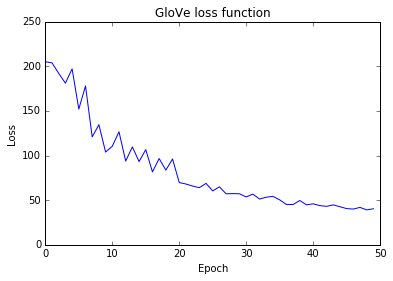

In [43]:
# Plot loss fn
def plot_loss_fn(losses, title):
    plt.plot(range(len(losses)), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.figure()

plot_loss_fn(losses, "GloVe loss function")

#### Tests: word similarity, word analogies

In [44]:
def get_word(word, model, word_to_ix):
    """
    returns the embedding that belongs to the given word (str)
    """
    return model.embeddings()[word_to_ix[word]]

In [45]:
vector = get_word("lupov", model, word_to_ix)
print(vector)

tensor([ 0.3648, -0.0519, -0.0263, -0.5178,  0.0834, -0.0161,  0.5632,  0.6154,
        -0.5049,  0.2271,  0.3217,  0.0170,  0.0616,  0.1479,  0.6156, -0.0939,
        -0.2456,  0.0683,  0.1398,  0.2605,  0.0317, -0.3788,  0.0700,  0.8735,
         0.4004,  0.4227, -0.2359,  0.1729, -0.4364, -0.0402, -0.3067, -0.6184,
         0.3040, -0.0342,  0.3564,  0.2884,  0.1523,  0.8375,  0.3730,  0.3199,
        -0.1104, -0.2765, -0.1177,  0.3219,  0.3092, -0.6014, -0.5400, -0.7912,
        -0.5602,  0.0829])


In [46]:
def closest(vec, word_to_ix, n=10):
    """
    finds the closest words for a given vector
    """
    all_dists = [(w, torch.dist(vec, get_word(w, model, word_to_ix))) for w in word_to_ix]
    return sorted(all_dists, key=lambda t: t[1])[:n]

In [47]:
closest(vector, word_to_ix)

[('lupov', tensor(0.)),
 ('two', tensor(2.9694)),
 ('world', tensor(3.0176)),
 ('clickings', tensor(3.0212)),
 ('circuits', tensor(3.0248)),
 ('man', tensor(3.0657)),
 ('when', tensor(3.0771)),
 ('still', tensor(3.1216)),
 ('questions', tensor(3.2087)),
 ('face', tensor(3.2146))]

In [48]:
# some helper fn
def print_tuples(tuples):
    for tuple in tuples:
        print('(%.4f) %s' % (tuple[1], tuple[0]))

In [49]:
# word analogies in the form w1 : w2 :: w3 : ?
def analogy(w1, w2, w3, n=5, filter_given=True):
    print('\n[%s : %s :: %s : ?]' % (w1, w2, w3))
   
    # w2 - w1 + w3 = w4
    closest_words = closest(get_word(w2, model, word_to_ix) - get_word(w1, model, word_to_ix) + get_word(w3, model, word_to_ix), word_to_ix)
    
    # Optionally filter out given words
    if filter_given:
        closest_words = [t for t in closest_words if t[0] not in [w1, w2, w3]]
        
    print_tuples(closest_words[:n])

In [50]:
analogy("lupov", "adell", "multivac")


[lupov : adell :: multivac : ?]
(4.2572) you
(4.2825) at
(4.4366) i
(4.5461) that
(4.5582) now
